import files from imdb data, filter to desired results. From a brief look at the data I can see that 1, there are movies that haven't come out yet; 2, there are movies without genres. Since neither of these will be helpful for my analysis I have decided to remove them. Additionally my rationale has determined that I don't want to look at movies before 2014 so I've removed those too. From the ratings data I am removing anything that has a low number of ratings since I don't consider that data significant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip')
df_filtered = df_imdb_basics[(df_imdb_basics['start_year'] <= 2020) & (df_imdb_basics['start_year'] >= 2014)]
df_filtered = df_filtered.dropna(subset=['genres'])
df_imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip')
df_imdb_ratings = df_imdb_ratings[(df_imdb_ratings['numvotes'] > 100)]
df_imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz', compression='gzip')

Now I am going to split out the genres into multiple columns.

In [3]:
df_filtered = df_filtered.dropna(subset=['genres'])
genres = df_filtered['genres'].str.split(",", n = 1, expand = True)
df_filtered['genre1']= genres[0]
df_filtered['genre2']= genres[1]
genres2 = df_filtered['genre2'].str.split(",", n = 1, expand = True)
df_filtered['genre2']= genres2[0]
df_filtered['genre3']= genres2[1]
df_filtered.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy,Drama,Fantasy
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,Comedy,None,None


I am choosing to use pandasql to join all the dataframes and make some queries about the data. First I'm joining the basics data with ratings, then I am joining the 'akas' data. Since I want to focus on US only data for this analysis this will help me filter out non-US market data.

In [4]:
from pandasql import sqldf
pysqldf =  lambda q: sqldf(q, globals())
q = '''SELECT *
        FROM df_filtered
        JOIN df_imdb_ratings
        USING(tconst)
        ;'''

imdb_joined_df = pysqldf(q)
imdb_joined_df.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517
1,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",Comedy,Drama,Fantasy,6.5,119


In [5]:
q = '''SELECT *
        FROM imdb_joined_df
        JOIN df_imdb_akas
        ON df_imdb_akas.title_id = imdb_joined_df.tconst
        ;'''

imdb_all = pysqldf(q)
imdb_all.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3,averagerating,numvotes,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517,tt0069049,1,O Outro Lado do Vento,BR,None,imdbDisplay,None,0.0
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None,6.9,4517,tt0069049,2,The Other Side of the Wind,US,None,imdbDisplay,None,0.0


Now I can filter the data to US only. I am also getting duplicates so I will clear those out.

In [6]:
imdb_all = imdb_all[imdb_all['region'] == 'US']
imdb_all = imdb_all.drop_duplicates(subset = 'tconst')

Next I'm working through my rating-by-genre calculation. I'll need a list of all the genres. 

First, I have a function that loops through all three genre columns, and creates a list of ratings for a given genre. It then outputs the average rating.

In [7]:
imdb_all['genre1'].unique()

array(['Drama', 'Adventure', 'Biography', 'Horror', 'Comedy', 'Action',
       'Crime', 'Animation', 'Thriller', 'Documentary', 'Fantasy',
       'Sci-Fi', 'Family', 'Mystery', 'Musical', 'Romance', 'Western',
       'History', 'Sport', 'Adult', 'War', 'Music'], dtype=object)

In [8]:
def avg_rating_by_genre(genre):
    averagerating_list = []
    for row in imdb_all.index:
        if (imdb_all['genre1'][row] == genre) | (imdb_all['genre2'][row] == genre) | (imdb_all['genre2'][row] == genre):
            averagerating_list.append(imdb_all['averagerating'][row])
    return np.mean(averagerating_list)

In [9]:
genres_list = ['Drama', 'Adventure', 'Biography', 'Horror', 'Comedy', 'Action',
       'Crime', 'Animation', 'Thriller', 'Documentary', 'Fantasy',
       'Sci-Fi', 'Family', 'Mystery', 'Musical', 'Romance', 'Western',
       'History', 'Sport', 'Adult', 'War', 'Music']

I want to see the averages for all in one place, so I will use the unique genres list to format that into a dictionary.

In [10]:
genre_dict = {}
for genre in genres_list:
    value = avg_rating_by_genre(genre)
    key = genre 
    genre_dict[key] = value

To make it easier to plot, I'm going to convert this into a dataframe and order it. 

In [11]:
genre_df = pd.DataFrame(list(genre_dict.items()),columns = ['Genre','Average Rating']) 
genre_df = genre_df.sort_values('Average Rating', ascending = False)

(0, 10)

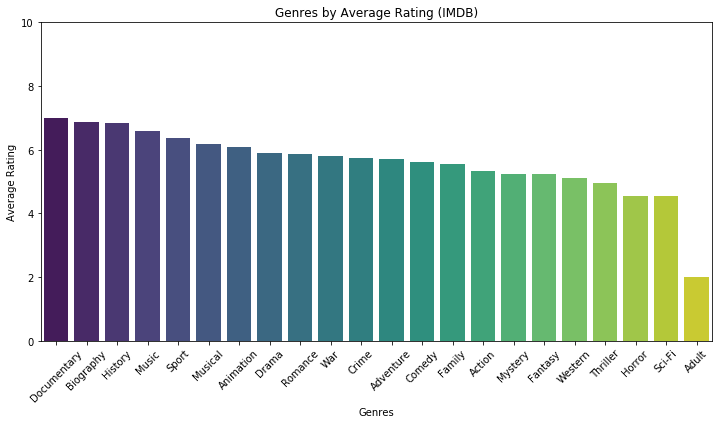

In [12]:
plt.figure (figsize=(10,6))
ax = sns.barplot(x=genre_df['Genre'], y=genre_df['Average Rating'], palette='viridis')
plt.title('Genres by Average Rating (IMDB)')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 10)

Interestingly, non-fiction genres like Biography, Documentary, History & Sport look to have highest ratings. Another contender is music/musical.

Note: I also took a look at the relationship between runtime and ratings, and didn't find any conclusive results. My recommendation would be to aim for a close to average runtime when working on movie parameters. The mean runtime looks to be 97 minutes with a standard deviation on the lower end, so between 1.5 and 2 hours is a good rainge to keep in mind.

In [20]:
imdb_all['runtime_minutes'].mean()
imdb_all['runtime_minutes'].std()

18.71284901507976